# Modelos cuánticos para la optimización de carteras de inversión

Este notebook implementa **tres enfoques diferentes** para resolver el mismo problema de optimización de portfolios: seleccionar una combinación de activos financieros que maximice el retorno esperado y minimice el riesgo, bajo ciertas restricciones como presupuesto máximo y retorno mínimo. Los métodos implementados son:

1. **Quantum Walks simuladas (NumPy)**: se utiliza una caminata probabilística inspirada en el paralelismo cuántico para explorar combinaciones de activos con bajo riesgo.

2. **Quantum Walks reales (Qiskit)**: se implementa un circuito cuántico que simula el desplazamiento de un walker sobre un grafo de carteras válidas, aprovechando la superposición cuántica.

3. **QAOA (Quantum Approximate Optimization Algorithm)**: el problema se formula como un QUBO y se resuelve mediante un circuito variacional que busca la configuración de cartera más eficiente.

# Quantum walks

Los *quantum walks* son la versión cuántica de los *random walks* clásicos. Mientras que una caminata clásica describe un proceso estocástico donde un "walker" se mueve entre nodos con ciertas probabilidades, en la caminata cuántica el estado del walker está en **superposición** de múltiples posiciones al mismo tiempo, y su evolución está gobernada por operadores **unitarios**.

El fenómeno de interferencia cuántica hace que algunas trayectorias se refuercen y otras se cancelen, lo que permite explorar espacios de soluciones de forma más eficiente que con métodos clásicos.

En este notebook, los quantum walks se utilizan para explorar configuraciones de activos financieros. Gracias a su capacidad para evaluar múltiples rutas simultáneamente, permiten encontrar combinaciones de carteras eficientes en términos de riesgo y retorno.


## Quantum Walk Simulado (NumPy)

Esta implementación emula un *quantum walk* mediante un proceso estocástico controlado, con el objetivo de recorrer el espacio de carteras de forma guiada y eficiente.

1. **Inicialización**:  
   Se parte de una cartera aleatoria válida generada mediante `random_valid_portfolio`, cumpliendo:
   - Presupuesto máximo.
   - Retorno mínimo esperado.
   - Al menos un activo seleccionado.

2. **Búsqueda local iterativa**:  
   Durante un número fijo de pasos:
   - Se generan 5 **vecinos** de la cartera actual, modificando aleatoriamente un activo (activación o desactivación).
   - Solo se conservan vecinos que también cumplan con las restricciones.

3. **Selección probabilística**:  
   A cada cartera vecina se le asigna una probabilidad inversa exponencial a su riesgo: $P_i \propto e^{-riesgo_i}$

   Este mecanismo penaliza soluciones con más riesgo y favorece aquellas con menor riesgo, simulando el efecto de interferencia constructiva característico de los *quantum walks* reales.

4. **Actualización de la trayectoria y evaluación**:  
   Se selecciona una cartera vecina según esas probabilidades y se convierte en la nueva solución candidata para la siguiente iteración.
   
   Si esta nueva cartera tiene una mayor eficiencia (retorno/riesgo) que la mejor conocida hasta el momento, se actualiza la solución óptima.

5. **Registro y visualización**:   
   Durante la simulación se guarda la evolución de las soluciones para visualizar la frontera eficiente alcanzada.

   Al finalizar, se muestra la mejor cartera encontrada y un gráfico que representa la evolución de riesgo y retorno, simulando la trayectoria del *quantum walk* en el espacio de búsqueda.



In [ ]:
!pip install "qiskit==0.44.0" "qiskit-aer==0.13.0" "qiskit-optimization==0.6.0" "qiskit-algorithms==0.2.1"

In [ ]:
import pandas as pd
import numpy as np
import random
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Carga y preparación de los datos:

In [ ]:
df = pd.read_csv("stocks_cleaned.csv")
df['return'] = df.groupby('Name')['close'].pct_change()

# Retorno promedio y precio promedio por activo
avg_returns = df.groupby('Name')['return'].mean()
avg_prices = df.groupby('Name')['close'].mean()

# Matriz de covarianza entre activos
pivot_returns = df.pivot(index='date', columns='Name', values='return')
cov_matrix = pivot_returns.cov()

# Filtrar activos válidos (sin NaNs)
valid_assets = avg_returns.dropna().index.intersection(avg_prices.dropna().index)
avg_returns = avg_returns[valid_assets]
avg_prices = avg_prices[valid_assets]
cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

In [ ]:
# 2. Parámetros del problema
budget = 10000
min_return = 0.001 # Diario
max_assets = 100   # limitar por complejidad
max_assets_qaoa = 15

# Seleccionar activos (limitar a N)
assets = avg_returns.index[:max_assets]
returns = avg_returns[assets].values
prices = avg_prices[assets].values
cov_matrix = cov_matrix.loc[assets, assets].values
num_assets = len(assets)

Funciones de evaluación:

In [ ]:
def evaluate_portfolio(selection):
    selected = selection.astype(bool)
    if not np.any(selected):
        return np.inf, 0, 0, 0  # Riesgo, coste, retorno, eficiencia

    sub_cov = cov_matrix[np.ix_(selected, selected)]
    weights = np.ones(sub_cov.shape[0]) / sub_cov.shape[0]  # pesos iguales

    risk = np.sqrt(weights @ sub_cov @ weights.T)
    cost = np.dot(selection, prices)
    ret = np.dot(selection, returns)
    efficiency = ret / risk if risk > 0 else 0
    return risk, cost, ret, efficiency

def random_valid_portfolio():
    while True:
        # Selección binaria aleatoria (0: no incluido, 1: incluido)
        selection = np.random.randint(0, 2, size=max_assets)
        cost = np.dot(selection, prices)
        ret = np.dot(selection, returns)
        # Aceptar solo si cumple restricciones y al menos un activo está seleccionado
        if cost <= budget and ret >= min_return and np.any(selection):
            return selection

Función que emula el comportamiento de los *quantum walks* en NumPy.


=== Mejor cartera encontrada ===
Activos seleccionados: ['A', 'AAPL', 'ABBV', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AIG', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMD', 'AME', 'AMP', 'ANDV', 'ANSS', 'ANTM', 'AOS', 'APA', 'APC', 'APD', 'APTV', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BBY', 'BDX', 'BEN', 'BF.B', 'BHGE', 'BK', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CBG', 'CBOE', 'CCI', 'CCL', 'CDNS', 'CERN', 'CF', 'CFG', 'CHK', 'CHRW', 'CHTR', 'CI']
Riesgo total: 0.008473
Inversión total: 4887.52€
Retorno esperado: 0.038850


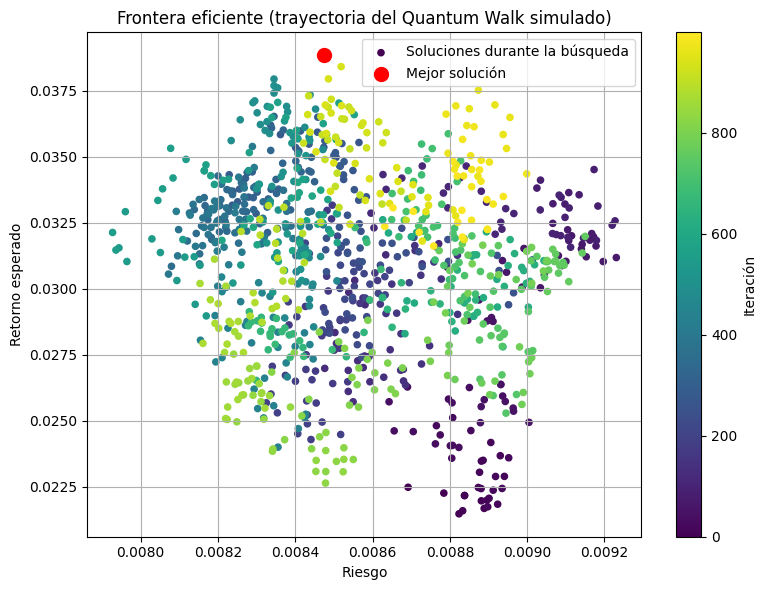

In [ ]:
def quantum_walk_simulation(steps=1000, log=False):
    # Inicializar con una cartera aleatoria válida
    current = random_valid_portfolio()
    best = current
    best_risk, best_cost, best_ret, best_eff = evaluate_portfolio(best)

    # Registrar la evolución si se activa el log
    solutions_log = [] if log else None

    for _ in range(steps):
        neighbors = []

        # Generar 5 vecinos modificando un activo aleatoriamente
        for _ in range(5):
            neighbor = current.copy()
            idx = random.randint(0, max_assets - 1)
            neighbor[idx] = 1 - neighbor[idx] # Activar o desactivar un activo

            # Verificar si el vecino cumple las restricciones
            cost = np.dot(neighbor, prices)
            ret = np.dot(neighbor, returns)
            if cost <= budget and ret >= min_return and np.any(neighbor):
                neighbors.append(neighbor)

        if not neighbors:
            continue    # Saltar iteración si no hay vecinos válidos

        # Calcular riesgos y asignar probabilidades inversas exponenciales
        risks = [evaluate_portfolio(n)[0] for n in neighbors]
        probabilities = np.exp(-np.array(risks))
        probabilities /= probabilities.sum() # Normalizar

        # Elegir siguiente cartera con probabilidad proporcional a menor riesgo
        idx = np.random.choice(len(neighbors), p=probabilities)
        current = neighbors[idx]

        # Evaluar la nueva cartera
        current_risk, current_cost, current_ret, current_eff = evaluate_portfolio(current)

        # Registrar la trayectoria si está activado el log
        if log:
            solutions_log.append((current_risk, current_ret))

        # Actualizar la mejor solución si es más eficiente
        if (
            current_eff > best_eff
            and current_cost <= budget
            and current_ret >= min_return
            and np.any(current)
        ):
            best = current
            best_risk = current_risk
            best_cost = current_cost
            best_ret = current_ret
            best_eff = current_eff

    # Evaluación final de la mejor cartera
    final_risk, final_cost, final_ret, final_eff = evaluate_portfolio(best)
    result = (best, (final_risk, final_cost, final_ret))
    if log:
        return result + (solutions_log,)
    return result

# Ejecutar simulación
best_selection, (final_risk, final_cost, final_return), risk_return_log = quantum_walk_simulation(log=True)

# Obtener nombres de los activos seleccionados
selected_assets = [assets[i] for i in range(max_assets) if best_selection[i] == 1]

print("\n=== Mejor cartera encontrada ===")
print("Activos seleccionados:", selected_assets)
print(f"Riesgo total: {final_risk:.6f}")
print(f"Inversión total: {final_cost:.2f}€")
print(f"Retorno esperado: {final_return:.6f}")

# Gráfico evolución de la búsqueda
risks, returns_ = zip(*risk_return_log)
iterations = range(len(risks))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(risks, returns_, c=iterations, cmap='viridis', s=20, label='Soluciones durante la búsqueda')
plt.colorbar(scatter, label="Iteración")

# Resaltar la mejor solución encontrada
plt.scatter([final_risk], [final_return], color='red', s=100, label='Mejor solución')

plt.xlabel("Riesgo")
plt.ylabel("Retorno esperado")
plt.title("Frontera eficiente (trayectoria del Quantum Walk simulado)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La cartera encontrada mediante el quantum walk cuántico representa una solución **diversificada y eficiente** que respeta las restricciones impuestas de retorno mínimo y presupuesto máximo.


**Diversificación:**   
  La cartera resultante incluye **63 activos distintos**, lo que sugiere una fuerte diversificación. Dado que la representación binaria no incorpora pesos proporcionales, se interpreta que cada activo incluido aporta la misma participación. Esta estrategia suele ser efectiva en escenarios donde se busca minimizar el riesgo global mediante exposición múltiple y distribución amplia.

**Presupuesto utilizado:**   
- Inversión total: 4887.52 €
- Esto supone menos del **50% del presupuesto máximo disponible**, lo cual puede parecer subóptimo desde el punto de vista de utilización de capital, pero refleja que el algoritmo priorizó combinaciones de activos con **alta eficiencia riesgo-retorno**, incluso si ello implicaba dejar parte del capital sin invertir.

**Riesgo y retorno total:**   
- **Riesgo** (desviación estándar diaria): 0.008473
- **Retorno** esperado diario: 0.038850

Esto representa una cartera con un **perfil eficiente**, en la que se alcanza un retorno notable con un riesgo contenido.

La relación retorno/riesgo (~4.59) indica una combinación favorable bajo la función objetivo del modelo.

**Activos seleccionados:**   
Entre los activos incluidos se encuentran tanto tecnológicas (AAPL, AMD, ADBE), como industriales (BA, CAT, HON), farmacéuticas (ABBV, BMY), aseguradoras (AIG, ALL), y financieras (BAC, AXP), lo que refuerza la idea de diversificación intersectorial.


**Trayectoria de búsqueda:**   
La figura muestra una nube densa de soluciones evaluadas, coloreadas por iteración. Se observa que el algoritmo explora activamente regiones del espacio riesgo-retorno antes de estabilizarse cerca de la mejor solución.
La **mejor cartera** se destaca en rojo, mostrando su posición relativa respecto al resto del conjunto.

En definitiva, este algoritmo fue capaz de encontrar una combinación altamente eficiente de activos.

## Quantum Walk Real (Qiskit)

Esta implementación ejecuta un *quantum walk* discreto utilizando circuitos cuánticos simulados en Qiskit, con el objetivo de explorar el espacio de carteras válidas mediante evolución cuántica y medición.

1. **Selección de carteras válidas**:  
   Se generan todas las combinaciones binarias posibles de activos (limitadas por complejidad computacional) y se seleccionan aquellas que:
   - No superan el presupuesto.
   - Alcanzan un retorno mínimo.
   - Contienen al menos un activo.

   De entre ellas, se escogen las 16 carteras más eficientes (según retorno/riesgo) para representarlas como estados de 4 qubits de posición.

2. **Inicialización en superposición**:  
   El sistema cuántico se inicializa en una superposición uniforme de las 16 carteras seleccionadas, aplicando puertas Hadamard a los qubits de posición.

3. **Evolución mediante quantum walk**:  
   Durante un número fijo de pasos:
   - Se aplica una puerta Hadamard al qubit de "coin", que decide aleatoriamente la dirección del movimiento.
   - Se aplican operadores de incremento y decremento que modifican la posición del walker en función del estado de la coin.

   Esta secuencia de operaciones simula un *quantum walk* sobre un grafo cíclico de carteras, permitiendo que el sistema evolucione mediante interferencias cuánticas.

4. **Medición y evaluación**:  
   Al finalizar la evolución, se mide el estado de los qubits de posición, colapsando la superposición en una cartera concreta.

   Se repite la medición 1024 veces para observar la distribución de colapsos, y se evalúan las carteras resultantes según riesgo, retorno y eficiencia.

5. **Selección de la mejor cartera y visualización**:  
   Se identifica la cartera colapsada más eficiente como solución final.

   Además, se generan dos gráficos:
   - Un histograma de frecuencias de medición (probabilidad de colapso de cada cartera).
   - Un diagrama riesgo-retorno coloreado por frecuencia, que representa la frontera eficiente obtenida por el *quantum walk* cuántico.


In [ ]:
# === Función de evaluación con matriz de covarianza real ===
def evaluate_portfolio(selection):
    # Convertir la selección binaria en un booleano (True si se selecciona el activo)
    selected = selection.astype(bool)

    if not np.any(selected):
        return np.inf, 0, 0, 0

    # Extraer la submatriz de covarianza de los activos seleccionados
    sub_cov = cov_matrix[np.ix_(selected, selected)]
    # Asignar pesos iguales a todos los activos seleccionados
    weights = np.ones(sub_cov.shape[0]) / sub_cov.shape[0]
    # Calcular el riesgo como la desviación estándar de la cartera (con fórmula cuadrática)
    risk = np.sqrt(weights @ sub_cov @ weights.T)
    # Calcular el coste total de los activos seleccionados
    cost = np.dot(selection, prices)
    # Calcular el retorno total esperado
    ret = np.dot(selection, returns)
    # Calcular la eficiencia como retorno dividido por riesgo (si hay riesgo)
    eff = ret / risk if risk > 0 else 0
    return risk, cost, ret, eff

Distribución cuántica:
{'1100': 56, '1101': 69, '1111': 57, '0001': 61, '0101': 69, '1001': 65, '0110': 58, '1000': 78, '1010': 62, '0100': 64, '1011': 67, '0011': 61, '0111': 63, '1110': 59, '0010': 72, '0000': 63}

=== Mejor cartera encontrada ===
Activos seleccionados: ['CHRW', 'CHTR', 'CI', 'CINF']
Riesgo total: 0.008953
Inversión total: 458.50€
Retorno esperado: 0.003231
Eficiencia: 0.360891


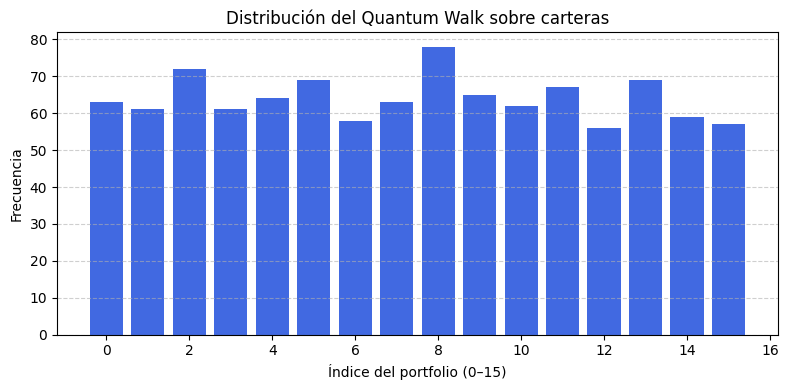

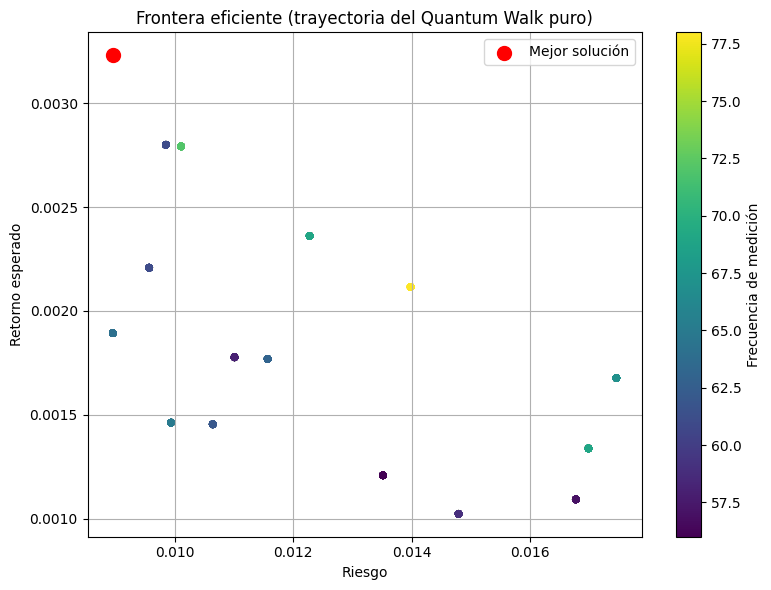

In [ ]:
# === Generar 16 carteras válidas y mapearlas a índices 0–15 ===
num_position_qubits = 4  # 4 qubits de posición -> 2^4 = 16 carteras distintas
max_portfolios = 2**num_position_qubits  # Total carteras a evaluar

# Construcción conjunto de candidatos
candidatos = []
for j in range(2 ** num_assets): # Explora todas las combinaciones posibles de carteras binarias
    if len(candidatos) >= max_portfolios:
        break # Nos quedamos solo con 16

    b = np.array(list(np.binary_repr(j, width=num_assets))).astype(int) # Conversión binaria
    cost = np.dot(b, prices)
    ret = np.dot(b, returns)
    if cost <= budget and ret >= min_return and np.any(b):
        risk, _, _, eff = evaluate_portfolio(b)
        candidatos.append((eff, b)) # Guardamos eficiencia y selección binaria

# Elegir las 16 carteras más eficientes y asignarles un índice (0 a 15)
top_portfolios = sorted(candidatos, reverse=True)[:16]
portfolio_map = {i: p[1] for i, p in enumerate(top_portfolios)}


# === Construir circuito quantum walk ===

# Puerta para incrementar la posición (dependiendo del coin qubit)
def increment_gate(qc, q, control):
    qc.cx(control, q[0])
    qc.ccx(control, q[0], q[1])
    qc.ccx(control, q[1], q[2])
    qc.ccx(control, q[2], q[3])

# Puerta para decrementar la posición (también dependiente del coin qubit)
def decrement_gate(qc, q, control):
    qc.x(control)
    for i in range(len(q)):
        qc.x(q[i])
    qc.ccx(control, q[2], q[3])
    qc.x(q[2])
    qc.ccx(control, q[1], q[2])
    qc.x(q[1])
    qc.ccx(control, q[0], q[1])
    qc.x(q[0])
    qc.cx(control, q[0])
    qc.x(control)


# === Circuito de quantum walk puro ===

def quantum_walk_circuit(steps=10):
    # Circuito con 1 qubit de coin y 4 de posición, más los 4 bits clásicos para medir
    qc = QuantumCircuit(1 + num_position_qubits, num_position_qubits)  # 1 coin + 4 posición

    # Inicializar los qubits de posición en superposición
    for i in range(1, 1 + num_position_qubits):
        qc.h(i)

    # Aplicar el quantum walk durante 'steps' pasos
    for _ in range(steps):
        qc.h(0)  # coin flip
        increment_gate(qc, [1, 2, 3, 4], 0)  # Movimiento hacia una dirección
        decrement_gate(qc, [1, 2, 3, 4], 0)  # Movimiento hacia la otra
        qc.barrier()

    # Medir solo los qubits de posición (la coin se ignora)
    for i in range(num_position_qubits):
        qc.measure(i + 1, i)

    return qc


# === Ejecutar simulación ===
qc = quantum_walk_circuit()
simulator = AerSimulator()
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts() # Resultados de las colapsos medidos (bitstrings)


# === Evaluar mediciones ===
risks, rets, freqs = [], [], [] # Para la gráfica de la frontera eficiente
best_eff = -np.inf
best_index = None
index_frequencies = {}

print("Distribución cuántica:")
print(counts)

# Evaluar cada bitstring colapsado
for state, freq in counts.items():
    idx = int(state, 2)
    if idx in portfolio_map:
        selection = portfolio_map[idx]
        risk, cost, ret, eff = evaluate_portfolio(selection)
        risks.extend([risk] * freq)
        rets.extend([ret] * freq)
        freqs.extend([freq] * freq)  # usar frecuencia como proxy de intensidad
        index_frequencies[idx] = freq
        if eff > best_eff:
            best_eff = eff
            best_index = idx

# === Mostrar mejor cartera ===
if best_index is not None:
    best_selection = portfolio_map[best_index]
    best_assets = [assets[i] for i in range(max_assets) if best_selection[i] == 1]
    best_risk, best_cost, best_ret, _ = evaluate_portfolio(best_selection)

    print("\n=== Mejor cartera encontrada ===")
    print("Activos seleccionados:", best_assets)
    print(f"Riesgo total: {best_risk:.6f}")
    print(f"Inversión total: {best_cost:.2f}€")
    print(f"Retorno esperado: {best_ret:.6f}")
    print(f"Eficiencia: {best_ret / best_risk:.6f}")
else:
    print("Ninguna cartera colapsada era válida.")


# === Gráfico 1: Distribución de colapsos por índice ===
plt.figure(figsize=(8, 4))
plt.bar(index_frequencies.keys(), index_frequencies.values(), color='royalblue')
plt.xlabel("Índice del portfolio (0–15)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Quantum Walk sobre carteras")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Gráfico 2: Frontera eficiente ===
plt.figure(figsize=(8, 6))
scatter = plt.scatter(risks, rets, c=freqs, cmap='viridis', s=20)
plt.colorbar(scatter, label="Frecuencia de medición")
if best_index is not None:
    plt.scatter([best_risk], [best_ret], color='red', s=100, label='Mejor solución')
plt.xlabel("Riesgo")
plt.ylabel("Retorno esperado")
plt.title("Frontera eficiente (trayectoria del Quantum Walk puro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La solución colapsada por este algoritmo representa una cartera **válida y eficiente**, aunque menos diversificada que la obtenida por el modelo anterior. El sistema evoluciona durante 10 pasos y colapsa sobre 1024 medidas, generando la distribución observada.


**Diversificación:**   
La cartera final incluye solo 4 activos: `CHRW`, `CHTR`, `CI`, `CINF`, lo que indica una estrategia más concentrada. Dado que el algoritmo opera sobre combinaciones binarias predefinidas (carteras válidas discretas), la diversificación depende directamente de las combinaciones seleccionadas en el mapeo inicial.

**Inversión total:**   
- Inversión total: 458.50 €
- Esto representa **menos del 5%** del presupuesto disponible, lo cual indica una fuerte subutilización del capital. Este comportamiento es coherente con el hecho de que ninguna de las combinaciones colapsadas con mayor frecuencia incluía activos de alto coste o alto retorno que además cumplieran las restricciones.

**Riesgo y retorno total:**   
- **Riesgo** (desviación estándar diaria): 0.008953
- **Retorno** esperado diario: 0.003231

La relación retorno/riesgo (0.361) es notablemente inferior a la obtenida en el modelo simulado, aunque dentro de los límites esperados considerando que solo se exploran 16 combinaciones posibles. El algoritmo logra cumplir las restricciones, pero sin alcanzar una frontera tan eficiente como la del *quantum walk* en NumPy.


**Distribución cuántica:**    
El histograma muestra una distribución **bastante uniforme** entre los 16 estados medidos.
- La cartera correspondiente al índice `1000` aparece como la más frecuente (78 veces), pero no es la mejor.
- La mejor solución (`1100`) colapsó 56 veces, lo que sugiere que **no hubo un sesgo** claro del circuito hacia carteras particularmente eficientes.

Esto podría deberse a una evolución con interferencias no suficientemente constructivas o a una codificación de carteras demasiado similar en eficiencia.

**Trayectoria en el plano riesgo-retorno:**   
En el gráfico de frontera eficiente, se observa que la mayoría de carteras tienen retorno bajo y riesgo moderado. La **mejor solución** (punto rojo) se sitúa en la esquina superior izquierda del conjunto, lo que indica que fue una de las más eficientes entre las opciones disponibles.

## Algoritmo QAOA

El algoritmo QAOA (*Quantum Approximate Optimization Algorithm*) es un **enfoque híbrido cuántico-clásico** diseñado para resolver problemas de optimización combinatoria. Se basa en construir un circuito cuántico parametrizado que explora el espacio de soluciones posibles, alternando operadores que representan la función objetivo y operadores de mezcla.

A diferencia del *quantum walk*, QAOA aplica una secuencia de puertas que aproximan la evolución del sistema cuántico bajo una función de coste definida como un **Hamiltoniano**. La solución óptima se aproxima al medir los estados colapsados tras múltiples ejecuciones del circuito, donde los estados con mayor probabilidad corresponden a combinaciones binarias que minimizan (o maximizan) la función objetivo.

### Implementación en este notebook:

1. **Formulación del problema como QUBO**:  
   El problema de optimización de cartera se codifica como un modelo cuadrático binario (*Quadratic Unconstrained Binary Optimization*, QUBO), donde cada variable binaria indica si se incluye un activo en la cartera o no.

   La función objetivo incluye:
   - **Término de riesgo**: minimización de la varianza (covarianza entre activos).
   - **Retorno esperado**: penalización negativa proporcional al retorno (a maximizar).
   - **Presupuesto**: penalización positiva por superar el coste máximo permitido.
   - **Retorno mínimo exigido**: penalización por no alcanzar un retorno mínimo global.

2. **Conversión a operador cuántico**:  
   El modelo QUBO se convierte en un operador cuántico mediante el uso de `QuadraticProgramToQubo` y se representa como una suma de operadores de Pauli (`SparsePauliOp`) sobre los qubits correspondientes a los activos.

3. **Construcción y ejecución del circuito QAOA**:  
   Se entrena un circuito QAOA de una sola capa (`reps=1`) utilizando el optimizador clásico COBYLA. El entrenamiento ajusta los ángulos del circuito para maximizar la probabilidad de colapsar en soluciones de baja energía (carteras óptimas).

4. **Colapso y selección de solución**:  
   El circuito se ejecuta en un simulador y se obtiene una distribución de probabilidades sobre posibles combinaciones binarias. Se selecciona el bitstring con mayor probabilidad como la solución final.

5. **Evaluación de la cartera resultante**:  
   Se interpreta la cadena binaria como una selección de activos, y se calcula:
   - El **riesgo total** (en base a la matriz de covarianza),
   - El **coste total** invertido,
   - El **retorno esperado** de la cartera.

   Esta solución representa una cartera eficiente que equilibra riesgo y retorno según los pesos definidos en el modelo QUBO.


Deseacalar los resultados para verlos con las unidades originales (retornos reales, costes en euros, etc.)

In [ ]:
n = len(assets)

# Crear modelo cuadrático: Seleccionar los primeros n activos para limitar el tam del problema
qp = QuadraticProgram()
for i in range(n):
    qp.binary_var(name=f"x{i}") # Se inlcuye o no

# Penalizaciones
penalty_return = 1000
penalty_budget = 1    # Penaliza violar el presupuesto
penalty_retmin = 1000  # Penaliza no alcanzar el retorno mínimo

linear = {}
quadratic = {}

# Riesgo (covarianza)
for i in range(n):
    for j in range(i, n):
        quadratic[(f"x{i}", f"x{j}")] = cov_matrix[i, j]

# Maximizar retorno esperado
for i in range(n):
    linear[f"x{i}"] = linear.get(f"x{i}", 0) - penalty_return * returns[i]

# Penalizar coste total (presupuesto excedido)
for i in range(n):
    for j in range(i, n):
        quadratic[(f"x{i}", f"x{j}")] = quadratic.get((f"x{i}", f"x{j}"), 0) + penalty_budget * prices[i] * prices[j]

# Penalizar si retorno < mínimo esperado
for i in range(n):
    for j in range(i, n):
        quadratic[(f"x{i}", f"x{j}")] += -penalty_retmin * returns[i] * returns[j]

qp.minimize(linear=linear, quadratic=quadratic)

# Convertir a QUBO
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
Q = qubo.objective.quadratic.to_array()
offset = qubo.objective.constant

# Operador cuántico
paulis = []
for i in range(n):
    if Q[i, i] != 0:
        z = np.zeros(n, dtype=bool)
        z[i] = True
        paulis.append((Q[i, i], Pauli((z, np.zeros(n, dtype=bool)))))
    for j in range(i + 1, n):
        if Q[i, j] != 0:
            z = np.zeros(n, dtype=bool)
            z[i] = True
            z[j] = True
            paulis.append((Q[i, j], Pauli((z, np.zeros(n, dtype=bool)))))

operator = SparsePauliOp.from_list([(p.to_label(), float(w)) for w, p in paulis])

# Ejecutar QAOA
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), reps=1)
result = qaoa.compute_minimum_eigenvalue(operator)

# Interpretar resultados
bitstring = max(result.eigenstate.binary_probabilities(), key=result.eigenstate.binary_probabilities().get)
x = np.array([int(b) for b in bitstring[::-1]])

# Evaluar resultado
selected_assets = [assets[i] for i in range(n) if x[i] == 1]
risk = x @ cov_matrix @ x.T # Riesgo
cost = np.dot(x, prices)
ret = np.dot(x, returns) # Retorno

print("Activos seleccionados:", selected_assets)
print(f"Riesgo total: {risk:.6f}")
print(f"Inversión total: {cost:.2f}€") # / {budget}")
print(f"Retorno esperado: {ret:.6f}")


Activos seleccionados: ['AAL', 'AAP', 'AAPL', 'ACN', 'ADP', 'ADSK']
Riesgo total: 0.003832
Inversión total: 532.22€
Retorno esperado: 0.004710


La cartera seleccionada mediante QAOA representa una solución compacta y eficiente, generada al resolver una formulación QUBO con restricciones suavizadas mediante penalizaciones dentro de la función objetivo.


**Diversificación:**  
La cartera incluye solo 6 activos: `AAL`, `AAP`, `AAPL`, `ACN`, `ADP`, `ADSK`, lo cual refleja una selección altamente focalizada. Este tipo de solución es esperable en QAOA cuando la función objetivo pondera con fuerza la eficiencia individual de cada activo y no penaliza directamente la baja diversificación.

**Retorno y riesgo total:**
- **Retorno** esperado diario: 0.004710
- **Riesgo** (desviación estándar diaria): 0.003832
- **Eficiencia** (retorno/riesgo): ≈ 1.23

Esta eficiencia es **moderadamente alta**, superior a la obtenida con el *quantum walk* en Qiskit (0.36), pero inferior a la del **quantum walk** simulado (4.59).

Aun así, el resultado refleja una **buena relación riesgo/retorno**, especialmente considerando que se limita el número de activos (15) por el tamaño del circuito y la complejidad del problema.

**Inversión total:**  
- Capital invertido: 532.22 €

Aunque por debajo del presupuesto máximo (10,000 €), QAOA no optimiza directamente la inversión total, ya que el modelo penaliza el exceso de gasto pero no incentiva el uso completo del presupuesto. El resultado sugiere que el modelo encontró una combinación eficiente sin necesidad de agotar el capital disponible.

**Activos seleccionados:**  
- La mayoría son empresas tecnológicas o del sector servicios con alta capitalización: `AAPL`, `ADP`, `ADSK`, `ACN`.
- La inclusión de `AAL` (American Airlines) y `AAP` (Advance Auto Parts) indica que el modelo también seleccionó activos no tradicionales si estos mejoraban la eficiencia general del portafolio.

En conclusión, QAOA ha generado una solución válida, de bajo riesgo y retorno aceptable, con una eficiencia competitiva en relación al resto de métodos cuánticos explorados. Aunque no explota el presupuesto completo ni busca diversificación explícita, cumple eficazmente su objetivo: encontrar una cartera binaria eficiente bajo una función objetivo penalizada.



# Conclusión general

**Quantum Walk simulado** es el enfoque que obtuvo la **mejor eficiencia global**, explorando una gran cantidad de soluciones mediante una estrategia inspirada en caminatas cuánticas. Aunque no agotó el presupuesto, encontró combinaciones altamente eficientes y diversificadas.

**Quantum Walk en Qiskit** ofrece una **implementación cuántica real**, pero su espacio de búsqueda está limitado por el número de qubits (16 carteras posibles). Aun así, fue capaz de cumplir las restricciones y colapsar una solución válida, aunque con baja diversificación y eficiencia.

**QAOA** se sitúa en un punto intermedio: logra una eficiencia aceptable con bajo riesgo, pero tiende a seleccionar carteras pequeñas y no aprovecha todo el capital disponible. Tiene la ventaja de permitir una formulación más estructurada del problema mediante QUBO.


Cada uno de los enfoques tiene sus fortalezas:
- **Quantum Walk Simulado**: Ideal para obtener soluciones eficientes y diversificadas rápidamente.
- **Quantum Walk Real (Qiskit)**: Útil como prueba de concepto de computación cuántica en finanzas.
- **QAOA**: Prometedor para integrar restricciones complejas en problemas de inversión, aunque requiere ajustes para potenciar la diversificación y uso del capital.

En conjunto, estos métodos muestran cómo diferentes estrategias cuánticas (reales o inspiradas) pueden abordar el problema de optimización de carteras desde ángulos complementarios.